# Кластеризация предложений

# Библиотеки

In [1]:
import json
import os
#from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter
import time

import pandas as pd

import numpy as np
import scipy
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util
#from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
import umap

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Home\anaconda3\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


# Функции

выделение кластера

In [2]:
def community_detection(embeddings, threshold=0.75, min_community_size=100, init_max_size=1000):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

def make_clusters_print(df, sentences='body', embeddings='embedding'):
    corpus_sentences = list(df[sentences])
    corpus_embeddings = list(df[embeddings])

    print("Start clustering")
    start_time = time.time()

    #Two parameter to tune:
    #min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
    #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
    clusters = community_detection(corpus_embeddings)

    print('Кол-во кластеров:', len(clusters))
    for cluster in range(len(clusters)):
        print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

    #Print all cluster / communities
    '''
    for i, cluster in enumerate(clusters):
        print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
        for sentence_id in cluster:
            print("\t", corpus_sentences[sentence_id])
    '''

    print("Clustering done after {:.2f} sec".format(time.time() - start_time))
    return clusters

def add_clusters_to_df(clusters,
                       df,
                       ):
    for i, cluster in enumerate(clusters):
        for row in cluster:
            try:
                df.iloc[row, -1] = i
            except:
                pass

отрисовка графика и понижение размерности

In [3]:
def plot_2d_pca_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with PCA
    '''
    pca = PCA(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = pca.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()


def plot_2d_tsne_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with TSNE
    '''
    tsne = TSNE(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = tsne.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()
    

def plot_2d_umap_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with UMAP
    '''
    reducer = umap.UMAP()
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = reducer.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()

# Предобученная модель

Скачиваем предобученную модель

In [4]:
#model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее

# Датасет трамп_байден2020 комментс

Проверям папку

In [5]:
comments_dir = r"\Users\Home\Documents\Data Science\comptech\2020_trump_biden"
os.listdir(comments_dir)[:5]

['JoeBiden_comments_2020_clean.csv', 'Trump_comments_2020_clean.csv']

In [6]:
%%time
d = dict()

for my_file in tqdm(os.listdir(comments_dir), position=0, leave=True):
    with open(os.path.join(comments_dir, my_file), encoding="utf8") as csv_file:
        d[my_file] = pd.read_csv(csv_file)

100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

Wall time: 3.5 s


In [7]:
# add part column with trump
d['Trump_comments_2020_clean.csv']['part'] = np.nan
d['Trump_comments_2020_clean.csv']['part'] = d['Trump_comments_2020_clean.csv']['part'].fillna('trump')

# add part column with biden
d['JoeBiden_comments_2020_clean.csv']['part'] = np.nan
d['JoeBiden_comments_2020_clean.csv']['part'] = d['JoeBiden_comments_2020_clean.csv']['part'].fillna('biden')

In [8]:
comments_df = pd.concat([d['Trump_comments_2020_clean.csv'], d['JoeBiden_comments_2020_clean.csv']])
del(d)
comments_df.shape

(1118386, 8)

In [9]:
comments_df.sample(2)

,Unnamed: 0,author,body,created_utc,link_id,parent_id,score,part
534313,534315,Calvin-ball,The problem is fundamentally I do not believe ...,1607217557,t3_k6n9zc,t1_gerbn74,1,trump
24472,24472,Womeisyourfwiend,It makes me feel like my head will explode,1583451904,t3_fdx5nv,t1_fjlot1y,1,biden


In [10]:
comments_df = comments_df.drop(['Unnamed: 0'], axis=1)

# Embedding

обрежем длинные комментарии до 512 слов

In [11]:
comments_df['body'] = comments_df['body'].astype('str')

In [12]:
def cut_comment(row):
    if len(row.split()) > 300:
        return ' '.join(list(row.split())[0][:200])
    else:
        return row

In [13]:
comments_df['body'] = comments_df['body'].apply(cut_comment)
comments_df.head(2)

,author,body,created_utc,link_id,parent_id,score,part
0,khalabrakis,"Fighters... That means warrior, like people wh...",1577836803,t3_ei6h2x,t3_ei6h2x,1,trump
1,Whopper_Jr,it is plausible that Republicans will never wi...,1577836806,t3_ei4ag7,t3_ei4ag7,1,trump


взяли выборку из 40 комментариев

In [14]:
%%time
comments_df = comments_df.sample(20000)  # пробуем на маленькой выборке
comment_embedding = model.encode(comments_df['body'].to_list(), show_progress_bar=True, convert_to_numpy=True, device='cuda')
comments_df['embedding'] = list(comment_embedding)


Wall time: 1min 20s


In [15]:
comments_df['part'].value_counts()

trump    11104
biden     8896
Name: part, dtype: int64

Сохраняем таблицу с вложениями

In [ ]:
#with open('/content/drive/My Drive/weights/comments_df.pickle', 'wb') as f:
#  pickle.dump(comments_df, f)

# Кластеризация fast_clustering

In [16]:
comments_df["label"] = np.nan
comments_df.head(2)

,author,body,created_utc,link_id,parent_id,score,part,embedding,label
191922,projecks15,As much as I hate Tucker I honestly rather lis...,1597852775,t3_icf9hx,t1_g243fh3,1,biden,"[0.6639614, -0.723506, 0.49978846, 0.046971478...",NaN
53383,OfficalCerialKiller,He also said he wants a VP who agrees with him...,1584932489,t3_fnaf7t,t1_fl8pepw,1,biden,"[0.51423246, -0.49690032, 0.16911244, -0.65210...",NaN


In [17]:
%%time
add_clusters_to_df(make_clusters_print(comments_df), comments_df)
comments_df.sample(2)

Start clustering
Кол-во кластеров: 5
Кол-во элементов в кластере 0: 4385
Кол-во элементов в кластере 1: 357
Кол-во элементов в кластере 2: 222
Кол-во элементов в кластере 3: 198
Кол-во элементов в кластере 4: 178
Clustering done after 14.20 sec
Wall time: 15.1 s


,author,body,created_utc,link_id,parent_id,score,part,embedding,label
601584,AbbadonCox,is not this the motherfucker with antifa ties ...,1608782480,t3_kj7g8l,t3_kj7g8l,1,trump,"[0.7028058, 0.22696997, 0.7162021, 0.11484241,...",0.0
280898,cbcbricks,"Keep dreaming loser, happy to know you will be...",1602042416,t3_j6iv0z,t1_g7yy6tr,1,biden,"[0.5087626, 0.35608092, 0.6874841, 0.018112317...",NaN


сохраняем полученную таблицу с кластерами и ембедингами в файл

In [32]:
with open(r"\Users\Home\Documents\Data Science\comptech\comments_df.pickle", 'wb') as f:
    pickle.dump(comments_df, f)

Смотррим на результаты

In [26]:
list(comments_df[comments_df['label'] == 0]['body'])[:50]

['As much as I hate Tucker I honestly rather listen to Shapiro speak. Tucker makes me want to punch his smug ugly face',
 "Totally with you. This one victory means so much. But I do not think we have a clear path to 2024. I worry about young R's like Josh Hawley, even the disabled kid from NC here that wants his constituents to cry. Trump proved that it likely was not his messaging that turned off voters, it was him. Which is absolutely horrifying.",
 "and the left scum in REDDIT are terrified of this 2020 coming election. I think there should new federal laws for all social media platforms to have to permit balanced opinions or their platform is forced to have warning posts that they are not open and fair. If anyone can demonstrate that their posts or feed are being removed can result in 'health warnings' for every post.",
 'This is some serious shit. Are we as a country going to let this slide? I hope not. Law and order president my ass',
 'How can a mayor prevent presidential ads fr

In [27]:
list(comments_df[comments_df['label'] == 1]['body'])[:50]

['Oh, sorry I meant any more proof*. Or were you just going to keep saying things without backing them up',
 "Not their AK, they 'found it'? Shady af",
 'Do you even know who you are talking to , of course they do not',
 'For me it is a dead link. I can not get to the article.',
 'Something about this just feels artificial.',
 '[Nothing like watching]( [Nothing like watching](',
 'I do not think she is on the list is she?',
 'You sure? you are using the “our”ending for words. you are not, are you? Be honest.',
 'Um... if a claim has been debunked, then it is not evidence.',
 'No shot. This is not a big enough story for them to do any damage control. They will just ignore.',
 'I was not able to watch either honestly.',
 'I am still not able to grasp that this is not satire',
 'I am literally just asking you for a source which you can not seem to produce',
 'What did the removed comment say?',
 'I have never been able to understand what they are complaining about. I honestly do not get i

In [28]:
list(comments_df[comments_df['label'] == 2]['body'])[:50]

['I think this is sound advice!',
 'Thank you for posting this. it is a delightful read:-)',
 'They will, they have made that very clear.',
 'Just reading your comment made my heart happy :)',
 'The Coalition of Decency! I like it. Thanks for the kind words.',
 'Since I now have your permission I will thanks',
 'you are a good man, thank you.',
 'My pleasure! Yes, that is true, look at OAN. Yahweh God Bless You! ',
 'Awesome, thank you both so much!',
 'Well, "Sanders *says* he will do the right thing"',
 'He just took the lead no?',
 'Thank you. Came here to say this exactly.',
 'Sounds to me like they are working just fine!',
 'The ending comments by that Senator were great!',
 ' Because reverting to name calling is a fantastic defence',
 'What a compelling and well-reasoned argument!',
 'This is amazing.I must adopt and deploy your strategy.',
 'Ah you are right thank you for correcting me. :)',
 'Ahh husband, you have the best posts!',
 'I think this is a great idea',
 'Welcome! We

In [29]:
list(comments_df[comments_df['label'] == 3]['body'])[:50]

['Great survey Biden was my first pick before he announced his candidacy. I voted for him in the SC primaries. Glad the country came around. 2. Warren 3. Pete 4. Harris 5. Beto 6. Booker 7. Klobuchar 8. Sanders 9. Yang 10. Steyer 11. Bloomberg 12. Gabbard',
 'Trump was an incumbent with high approvals on the economy....either way, 50.8 to 47.5 is what it currently is. He should reach a near 5% margin in the popular vote (currently projected at 4.8% according to my quick math) once CA and NY report',
 'I would like to believe Biden is going to win Pennsylvania, and I know he is up and the mail-in votes they have been counting have been like 80% in his favor, BUT I am worried about the 100k provisional ballots that still need to be counted. Those are in-person votes, and it is been clear who those voters were.',
 'Also mentioned there is that Hillary raised $53 million more than Trump. So raising money is not everything. it is how you spend it that wins the election.',
 ' GA: +7,248 Bide

## понижение размерности PCA

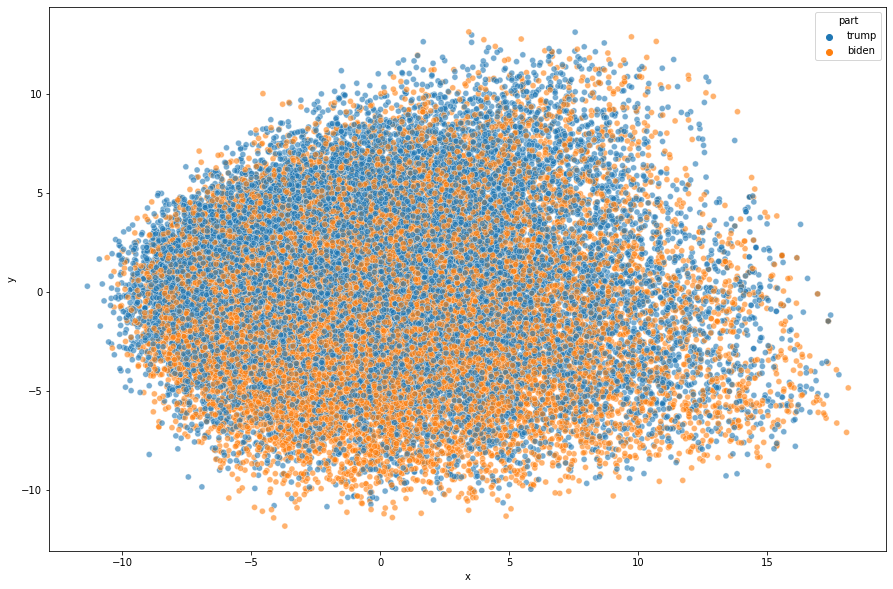

In [22]:
%%time
plot_2d_pca_representation_of_sentence(comments_df, alpha=0.6, label='part')

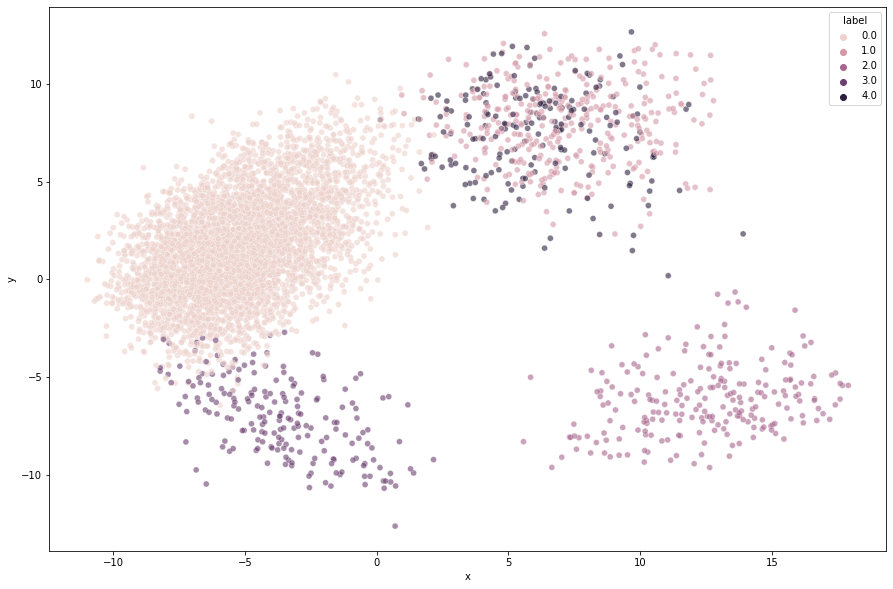

Wall time: 6.44 s


In [18]:
%%time
plot_2d_pca_representation_of_sentence(comments_df, alpha=0.6)

## Понижение размерности TSNE

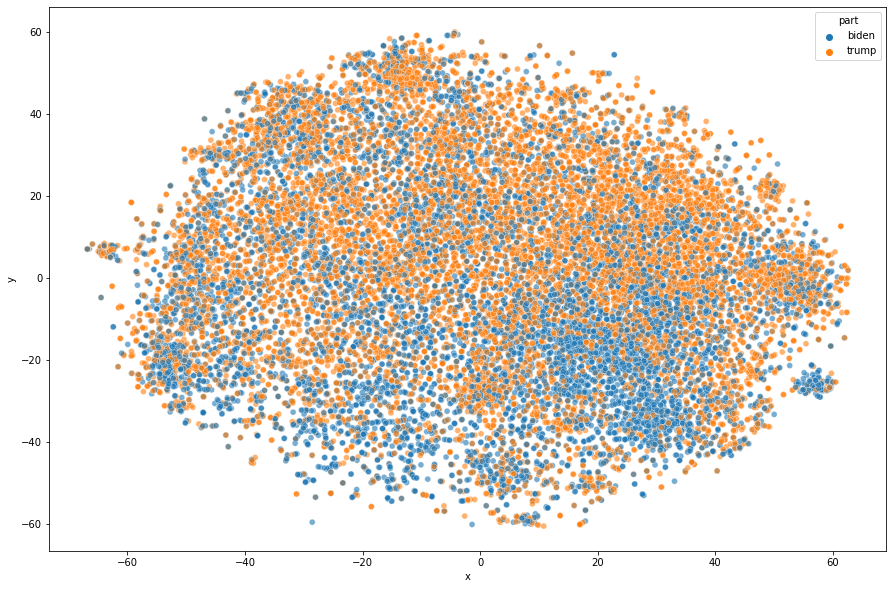

Wall time: 13min 19s


In [19]:
%%time
plot_2d_tsne_representation_of_sentence(comments_df, alpha=0.6, label='part')

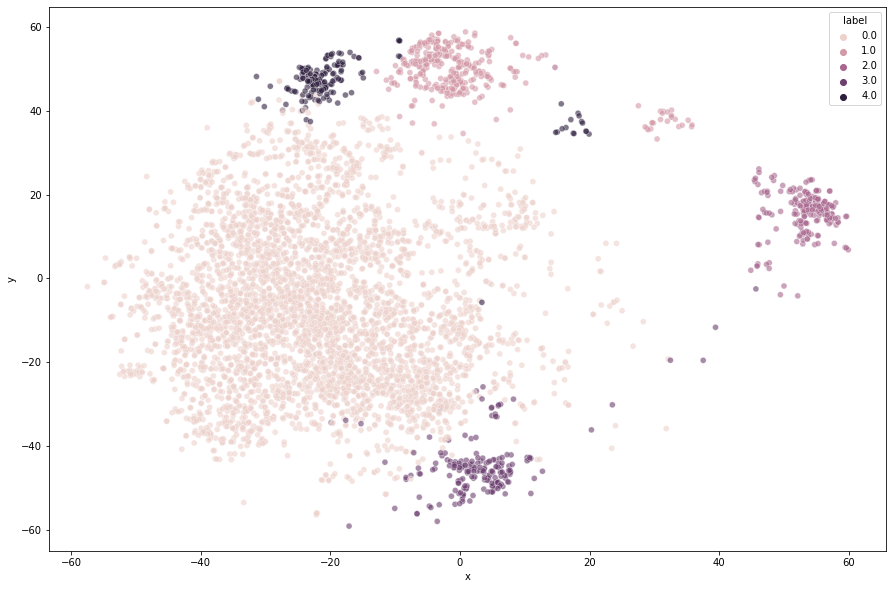

Wall time: 13min 33s


In [20]:
%%time
plot_2d_tsne_representation_of_sentence(comments_df, alpha=0.6)

## Понижение размерности umap

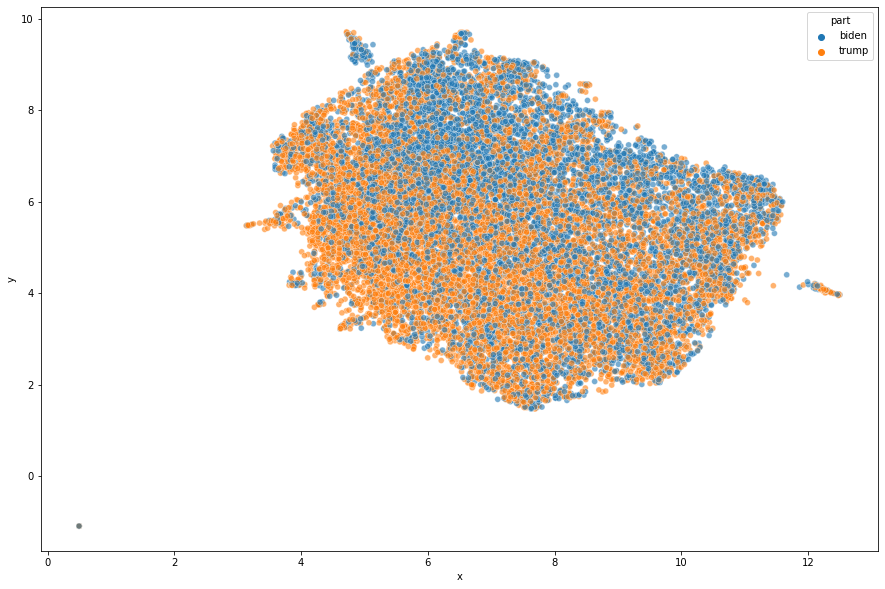

Wall time: 25.4 s


In [21]:
%%time
plot_2d_umap_representation_of_sentence(comments_df, alpha=0.6, label='part')

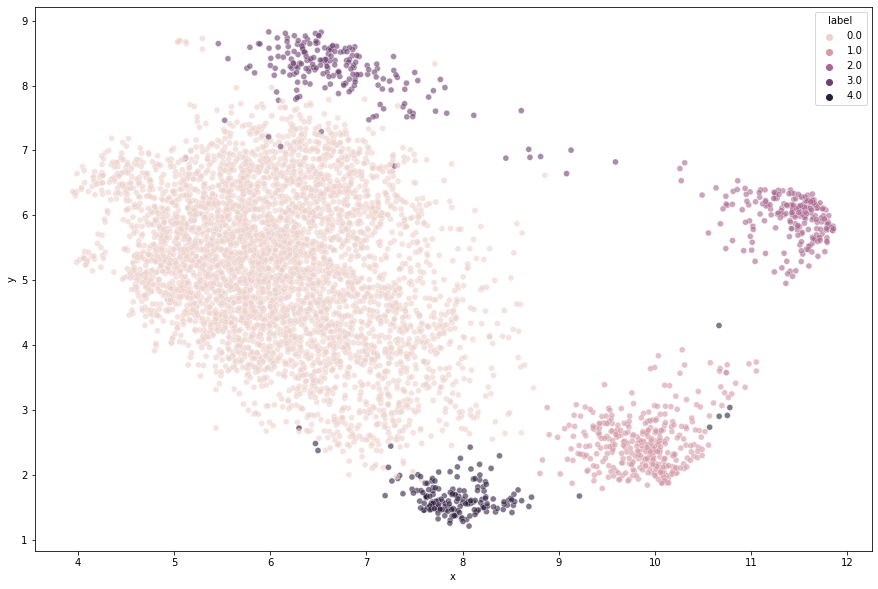

Wall time: 13.9 s


In [22]:
%%time
plot_2d_umap_representation_of_sentence(comments_df, alpha=0.6)